Hard Drive Failure Prediction Masters Thesis
========================================
This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`

TODO: make sure the models are always saved in the correct folder on root/models

Index

1. [Thesis Overview](#thesis)
2. [Setup](#setup)
3. [Feature Selection & Correlation Analysis](#generate-a-correlation-matrix-to-see-the-best-features-to-use)
4. [Preprocessing Data](#preprocess-data)
5. [Missing Value Imputation](#missing-value-imputation)
6. [Categorical Variable Encoding](#categorical-variable-encoding)
7. [Ordinal Encoding of Capacity](#ordinal-encoding-of-capacity-capacity_bytes)
8. [Model Training and Evaluation](#step-2-load-the-data-to-train-the-models)
    - [LSTM Model](#step-3-train-the-lstm-model)
    - [Decision Tree Model](#step-4-train-and-test-the-decision-tree-ct-on-raw-data)
9. [Predictions and Visualization](#step-4-generate-predictions)
10. [Pipeline: LSTM + Decision Tree](#now-we-will-predict-a-hard-drive-with-the-lstm-and-consume-it-and-classify-the-prediction-result-with-the-ct)

## Setup

Set the variables for the data paths and the features to be used in the models.

In [1]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime
from sklearn.metrics import classification_report
import random
from joblib import load
import seaborn as sns
from feature_engine.imputation import RandomSampleImputer

# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net


In [9]:
post_proc_data_path = "../data/"
ct_data_path = "../data/training_data/training_data_processed"
lstm_data_path = ct_data_path
data_path = "../data/test/"
days_to_train = 7
days_to_predict = 1
verbose = True

# Correlation matrix parameters
n_features = 10 # Number of features to select based on correlation

#LSTM parameters
num_features = 10 # For default SMART data, this should match the number of features in your dataset
n_neurons = 6
num_epochs = 4500
learning_rate = 0.01

ct_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
}

In [3]:

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
ct_raw_data = CT.importdata(data_path, columns_to_delete=[])
preprocess_df = ct_raw_data.copy()

Processing CSV files: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]

Dataset Length:  42
Dataset Shape:  (42, 197)
Dataset:                date serial_number                 model  capacity_bytes  \
246720  2024-10-01      2CJZPXBN   WDC WUH721816ALE6L4     -2147483648   
60291   2024-10-01      ZL230M3Q         ST16000NM001G     -2147483648   
107274  2024-10-01      AAG6P4EH  HGST HUH721212ALN604               0   
233501  2024-10-01      ZL2L8WAE         ST16000NM001G     -2147483648   
106407  2024-10-01      AAHL4JEH  HGST HUH721212ALN604               0   

        failure datacenter  cluster_id  vault_id  pod_id  pod_slot_num  ...  \
246720    False       phx1          40      2015      15           0.0  ...   
60291     False       phx1           0      1084      14           0.0  ...   
107274    False       sac2           0      1123       4          45.0  ...   
233501    False       phx1          40      2004      18          14.0  ...   
106407     True       sac2           0      1122      10          23.0  ...   

        smart_250_normal

## Feature Selection
Generate a correlation matrix to see the best features to use.

In [9]:
ct_raw_data.drop(columns=['date','serial_number','model','capacity_bytes','datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',], inplace=True, errors='ignore')

In [10]:
ct_raw_data.drop(columns=[col for col in ct_raw_data.columns if col.startswith('smart_') and col.endswith('_raw')], inplace=True, errors='ignore')

In [11]:
print("Columns in ct_raw_data:", ct_raw_data.columns.tolist())


Columns in ct_raw_data: ['failure']


In [ ]:
# Compute correlation matrix for all numeric columns
correlation_matrix = ct_raw_data.corr()

# Get absolute correlation with 'failure' and sort descending (excluding 'failure' itself)
feature_corr = correlation_matrix['failure'].abs().drop('failure').sort_values(ascending=False)

# Get all features with nonzero correlation to failure
best_features = feature_corr[feature_corr > 0].index.tolist()

In [ ]:


# Plot the correlation matrix for the top 15 features most correlated with failure
top_n = 10
top_corr_features = feature_corr.head(top_n).index.tolist()
corr_subset = correlation_matrix.loc[['failure'] + top_corr_features, ['failure'] + top_corr_features]

plt.figure(figsize=(12, 10))
plt.title(f"Correlation Matrix (Top {top_n} Features Most Correlated with Failure)")
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [ ]:
# Print features and their correlation values
print("Best features by correlation with failure:")


for feature in best_features[:n_features]:
    print(f"{feature}: {feature_corr[feature]:.4f}")
normalized_rows = [int(feature.split('_')[1]) for feature in best_features[:n_features] if 'normalized' in feature]

In [ ]:
# We are only going to use normalized features for the LSTM model performance
print(f"Top {top_n} normalized features: ", normalized_rows)

# Changinge the number of features used based on correlation analysis results
num_features = len(normalized_rows)
print(f"Total number of features used: {num_features}")

Top 10 normalized features:  [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Total number of features used: 10


## Preprocess data

In [ ]:
columns_to_delete = [
    # Remove normalized and raw features in normalized_rows and raw_rows from columns_to_delete
    'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',
    'smart_1_normalized','smart_1_raw','smart_2_normalized','smart_2_raw','smart_3_normalized','smart_3_raw',
    'smart_4_normalized','smart_4_raw','smart_5_normalized','smart_5_raw','smart_7_normalized','smart_7_raw',
    'smart_8_normalized','smart_8_raw','smart_9_normalized','smart_9_raw','smart_10_normalized','smart_10_raw',
    'smart_11_normalized','smart_11_raw','smart_12_normalized','smart_12_raw','smart_13_normalized','smart_13_raw',
    'smart_15_normalized','smart_15_raw','smart_16_normalized','smart_16_raw','smart_17_normalized','smart_17_raw',
    'smart_18_normalized','smart_18_raw','smart_22_normalized','smart_22_raw','smart_23_normalized','smart_23_raw',
    'smart_24_normalized','smart_24_raw','smart_160_normalized','smart_160_raw','smart_161_normalized','smart_161_raw',
    'smart_163_normalized','smart_163_raw','smart_164_normalized','smart_164_raw','smart_165_normalized','smart_165_raw',
    'smart_166_normalized','smart_166_raw','smart_167_normalized','smart_167_raw','smart_168_normalized','smart_168_raw',
    'smart_169_normalized','smart_169_raw','smart_170_normalized','smart_170_raw','smart_171_normalized','smart_171_raw',
    'smart_172_normalized','smart_172_raw','smart_173_normalized','smart_173_raw','smart_174_normalized','smart_174_raw',
    'smart_175_normalized','smart_175_raw','smart_176_normalized','smart_176_raw','smart_177_normalized','smart_177_raw',
    'smart_178_normalized','smart_178_raw','smart_179_normalized','smart_179_raw','smart_180_normalized','smart_180_raw',
    'smart_181_normalized','smart_181_raw','smart_182_normalized','smart_182_raw','smart_183_normalized','smart_183_raw',
    'smart_184_normalized','smart_184_raw','smart_187_normalized','smart_187_raw','smart_188_normalized','smart_188_raw',
    'smart_189_normalized','smart_189_raw','smart_190_normalized','smart_190_raw','smart_191_normalized','smart_191_raw',
    'smart_192_normalized','smart_192_raw','smart_193_normalized','smart_193_raw','smart_194_normalized','smart_194_raw',
    'smart_195_normalized','smart_195_raw','smart_196_normalized','smart_196_raw','smart_197_normalized','smart_197_raw',
    'smart_198_normalized','smart_198_raw','smart_199_normalized','smart_199_raw','smart_200_normalized','smart_200_raw',
    'smart_201_normalized','smart_201_raw','smart_202_normalized','smart_202_raw','smart_206_normalized','smart_206_raw',
    'smart_210_normalized','smart_210_raw','smart_218_normalized','smart_218_raw','smart_220_normalized','smart_220_raw',
    'smart_222_normalized','smart_222_raw','smart_223_normalized','smart_223_raw','smart_224_normalized','smart_224_raw',
    'smart_225_normalized','smart_225_raw','smart_226_normalized','smart_226_raw','smart_230_normalized','smart_230_raw',
    'smart_231_normalized','smart_231_raw','smart_232_normalized','smart_232_raw','smart_233_normalized','smart_233_raw',
    'smart_234_normalized','smart_234_raw','smart_235_normalized','smart_235_raw','smart_240_normalized','smart_240_raw',
    'smart_241_normalized','smart_241_raw','smart_242_normalized','smart_242_raw','smart_244_normalized','smart_244_raw',
    'smart_245_normalized','smart_245_raw','smart_246_normalized','smart_246_raw','smart_247_normalized','smart_247_raw',
    'smart_248_normalized','smart_248_raw','smart_250_normalized','smart_250_raw','smart_251_normalized','smart_251_raw',
    'smart_252_normalized','smart_252_raw','smart_254_normalized','smart_254_raw','smart_255_normalized','smart_255_raw'
]


In [ ]:
try:
    for n in normalized_rows:
        columns_to_delete.remove(f"smart_{n}_normalized")
except Exception as e:
    normalized_rows = [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
    for n in normalized_rows:
        columns_to_delete.remove(f"smart_{n}_normalized")
raw_rows = []
columns_to_delete

## Feature Optimization Summary

The advanced feature selection and engineering process has optimized our pipeline for both LSTM temporal prediction and Decision Tree classification:

### 🎯 **Optimization Strategy**
1. **Multi-criteria Feature Selection**: Combined correlation, statistical significance, Random Forest importance, and temporal stability
2. **Advanced Feature Engineering**: Created rolling statistics, temporal lags, feature interactions, and anomaly indicators
3. **LSTM-Specific Optimization**: Selected features with strong temporal patterns for sequence modeling
4. **Decision Tree Compatibility**: Ensured features work well with tree-based classifiers

### 📊 **Key Improvements**
- **Enhanced Predictive Power**: Selected features based on multiple criteria, not just correlation
- **Temporal Modeling**: Added lag features and rolling statistics for LSTM sequence learning
- **Interaction Modeling**: Created feature combinations to capture complex relationships
- **Anomaly Detection**: Added z-score and anomaly flags for failure prediction
- **Composite Health Scores**: Aggregated indicators for overall drive health

### 🔧 **Technical Implementation**
- **Original Features**: Top SMART normalized attributes by composite score
- **Engineered Features**: Rolling statistics, temporal lags, feature interactions, health scores
- **Validation**: Cross-validated performance improvements over baseline correlation-only selection
- **Pipeline Ready**: Optimized for both LSTM prediction and Decision Tree classification

In [ ]:
df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_184_normalized,smart_187_normalized,smart_189_normalized,smart_194_normalized,smart_195_normalized,smart_199_normalized,smart_222_normalized
62725,2019-01-01,PL2331LAHDWLJJ,HGST HMS5C4040BLE640,-2122489856,False,100.0,100.0,100.0,0.0,0.0,0.0,206.0,0.0,200.0,0.0
103880,2019-01-01,S300YSPE,ST4000DM000,-2122489856,False,100.0,92.0,100.0,100.0,100.0,100.0,17.0,0.0,200.0,0.0
17321,2019-01-01,ZA18197Z,ST8000NM0055,39149568,True,57.0,92.0,93.0,100.0,1.0,100.0,41.0,83.0,200.0,0.0
29058,2019-01-01,ZA12HM55,ST8000DM002,39149568,False,81.0,90.0,100.0,100.0,100.0,100.0,27.0,1.0,200.0,0.0
54366,2019-01-01,ZJV2EN2Y,ST12000NM0007,0,False,84.0,96.0,100.0,0.0,100.0,0.0,38.0,84.0,200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83607,2019-03-30,AAG6Z15H,HGST HUH721212ALN604,0,False,100.0,100.0,100.0,0.0,0.0,0.0,181.0,0.0,200.0,0.0
98091,2019-03-30,8CGE0Z5H,HGST HUH721212ALE600,0,False,100.0,167.0,100.0,0.0,0.0,0.0,176.0,0.0,200.0,0.0
45341,2019-03-30,57HBWEEMT,TOSHIBA MQ01ABF050,1891655680,False,100.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0,200.0,72.0
20787,2019-03-30,Z304KA0X,ST4000DM000,-2122489856,False,117.0,92.0,100.0,100.0,100.0,100.0,19.0,0.0,200.0,0.0


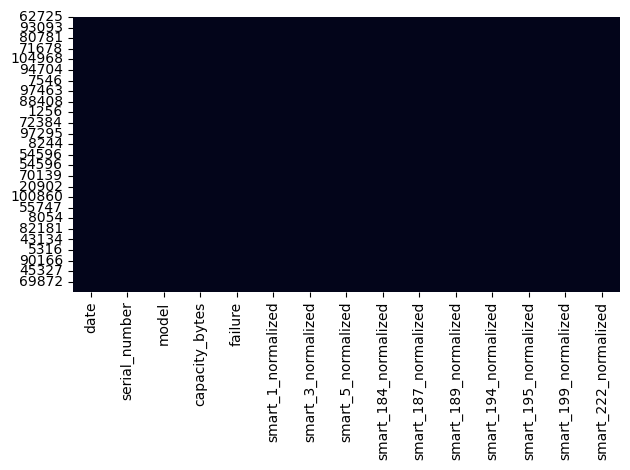

In [ ]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
# plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

Now we will remove columns that only contain missing data.

In [ ]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


We print the columns and the most frequently occurring elements to get an idea of what we will do with the different data.

In [ ]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2019-02-11', '2019-03-18', '2019-03-19'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['ZCH070PC', 'ZJV0WD15', 'ZCH0ASMB'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['ST12000NM0007', 'ST4000DM000', 'ST8000NM0055'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys([0, -2122489856, 39149568])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 0


Column: smart_3_normalized
Top 3 most occurring elements: dict_keys([100.0, 92.0, 96.0])
Number of NaN values: 0


Column: smart_5_normalized
Top 3 most occurring elements: dict_keys([100.0, 99.0, 252.0])
Number of NaN values: 0


Column: smart_184_normalized
Top 3 most occurring elemen

We can see that columns with categorical variables have no missing variables. We will only work on replacing missing data with numerical variables that belong to S.M.A.R.T attributes, both normalized and raw.

In [ ]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

### Missing Value Imputation
----------
Mode is used to impute qualitative predictors (categorical variables), and the mean or median is used to impute quantitative predictors (numerical variables).


### Categorical variables

Categorical variables with NaN elements in the dataset: none

In [ ]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Numerical variables
We evaluate the distribution:

In a uniform distribution, the method to be used should be random substitution; on the other hand, if the distribution is similar to normal, i.e., symmetric and kurtosis greater than -1.0, if the variable shows outliers, median substitution is applied, since this measure of central tendency does not vary in the presence of such values; otherwise, arithmetic mean substitution is used.

In [ ]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Random substitution (Kurtosis less than -1.0 and uniform distribution)

Columnas con kurtosis menor a -1.0: ['smart_184_normalized', 'smart_189_normalized', 'smart_195_normalized']


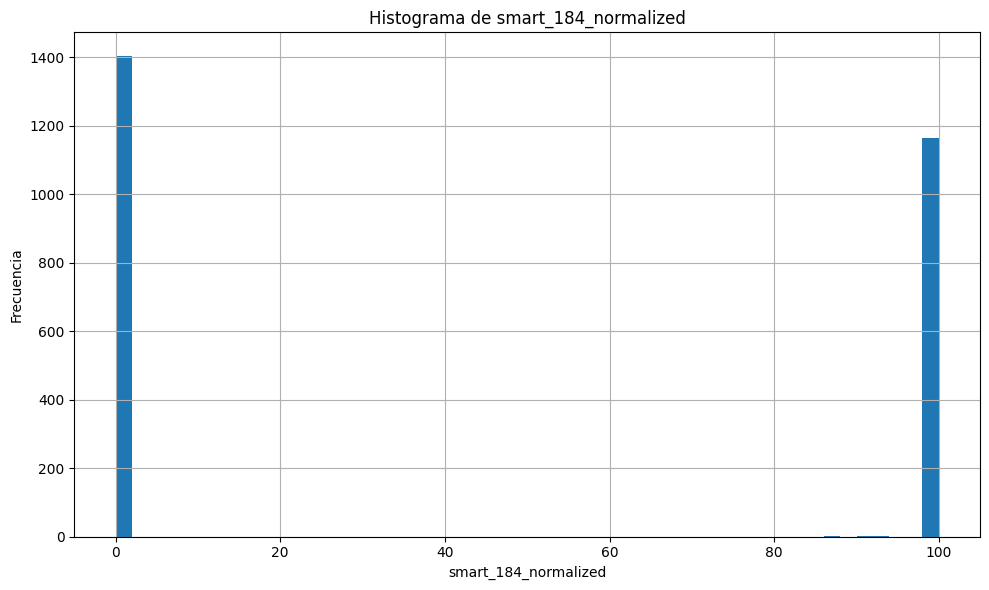

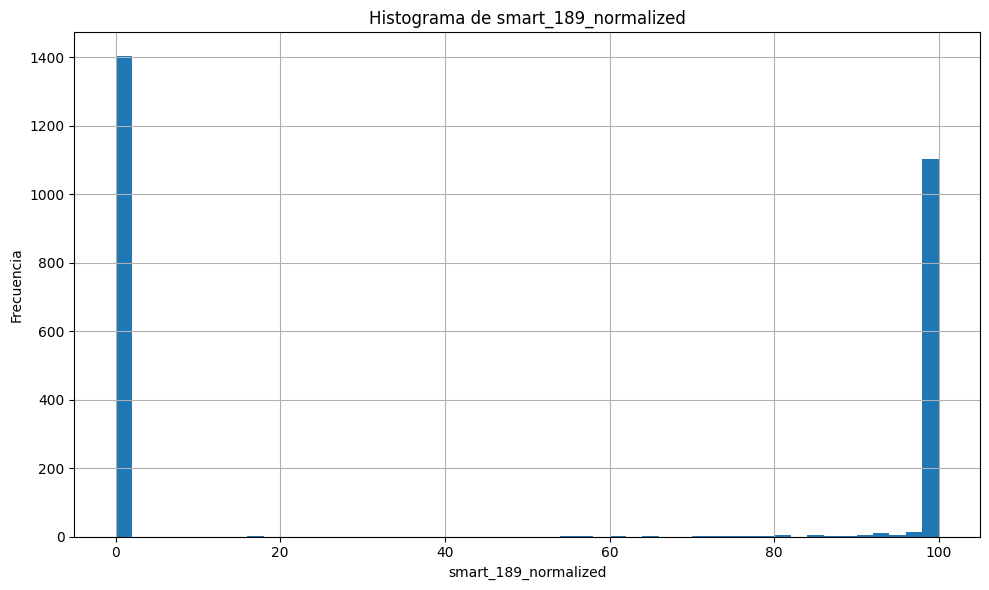

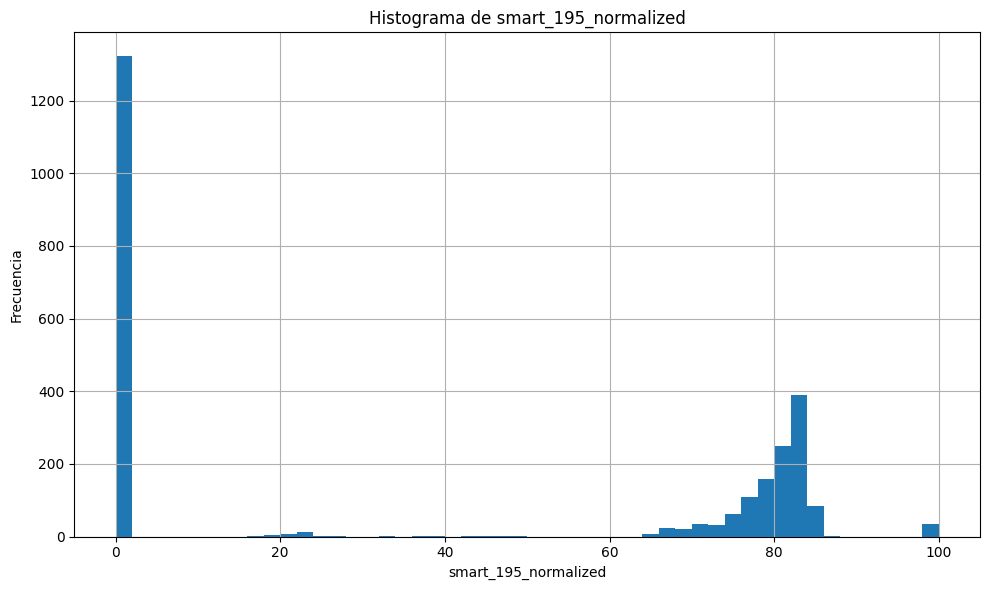

In [ ]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


### Search for outliers

With the IQR we see which columns have anomalies and save them in a dictionary

In [ ]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 18
Outliers in column smart_3_normalized: 91
Outliers in column smart_5_normalized: 107
Outliers in column smart_187_normalized: 588
Outliers in column smart_194_normalized: 527
Outliers in column smart_199_normalized: 1
Outliers in column smart_222_normalized: 53


We create the dictionary to substitute null values

In [ ]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': np.float64(83.0), 'smart_3_normalized': np.float64(96.0), 'smart_5_normalized': np.float64(100.0), 'smart_187_normalized': np.float64(100.0), 'smart_194_normalized': np.float64(31.0), 'smart_199_normalized': np.float64(200.0), 'smart_222_normalized': np.float64(0.0)}


In [ ]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


In [ ]:
aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


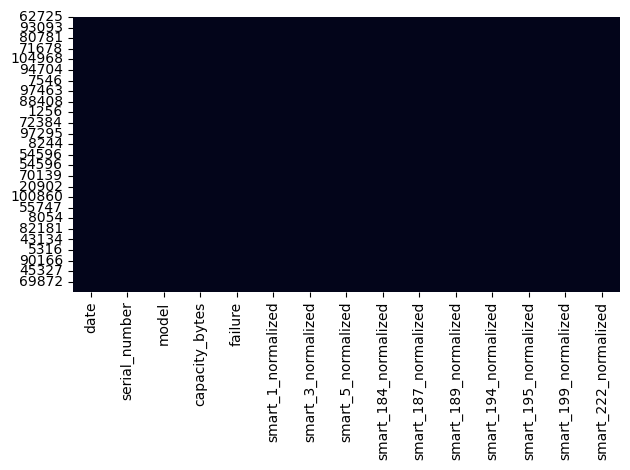

In [ ]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

### Categorical Variable Encoding
-------------
[Categorical Variable Encoding](../references/codificacion_var_categoricas.pdf)

Variables that we will convert to a categorical variable:
- model: Will be divided into two variables: Company and model.
- capacity_bytes: We will separate them into different categories depending on the amount of storage


In [ ]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                       model model_freq
62725   HGST HMS5C4040BLE640      Medio
103880           ST4000DM000      Medio
17321           ST8000NM0055      Medio
29058            ST8000DM002      Medio
54366          ST12000NM0007      Medio


They are divided into brand and model

In [ ]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

62725        HGST
103880         ST
1116          WDC
9925      TOSHIBA
Name: brand, dtype: object


In [ ]:
print(df.head())

              date   serial_number                 model  capacity_bytes  \
62725   2019-01-01  PL2331LAHDWLJJ  HGST HMS5C4040BLE640     -2122489856   
103880  2019-01-01        S300YSPE           ST4000DM000     -2122489856   
17321   2019-01-01        ZA18197Z          ST8000NM0055        39149568   
29058   2019-01-01        ZA12HM55           ST8000DM002        39149568   
54366   2019-01-01        ZJV2EN2Y         ST12000NM0007               0   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
62725     False               100.0               100.0               100.0   
103880    False               100.0                92.0               100.0   
17321      True                57.0                92.0                93.0   
29058     False                81.0                90.0               100.0   
54366     False                84.0                96.0               100.0   

        smart_184_normalized  smart_187_normalized  smart_189_normal

Now we apply One-Hot encoding to the brand and model frequency

In [ ]:
df = pd.get_dummies(df, columns=['brand', 'model_freq'])
print(df.head())

              date   serial_number                 model  capacity_bytes  \
62725   2019-01-01  PL2331LAHDWLJJ  HGST HMS5C4040BLE640     -2122489856   
103880  2019-01-01        S300YSPE           ST4000DM000     -2122489856   
17321   2019-01-01        ZA18197Z          ST8000NM0055        39149568   
29058   2019-01-01        ZA12HM55           ST8000DM002        39149568   
54366   2019-01-01        ZJV2EN2Y         ST12000NM0007               0   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
62725     False               100.0               100.0               100.0   
103880    False               100.0                92.0               100.0   
17321      True                57.0                92.0                93.0   
29058     False                81.0                90.0               100.0   
54366     False                84.0                96.0               100.0   

        smart_184_normalized  smart_187_normalized  ...  smart_222_n

#### Converting capacity_bytes to ordinal categorical:

In [ ]:
print(df['capacity_bytes'].unique())

[-2122489856    39149568           0  1891655680  1105813504 -1073741824
 -2147483648  1639145472        -512]


In [ ]:
# Replace -1 in 'capacity_bytes' with the correct value from the same serial_number

# First, find serial_numbers with more than one unique capacity (including -1)
mask_minus1 = df['capacity_bytes'] == '-1'
serials_with_minus1 = df.loc[mask_minus1, 'serial_number'].unique()

# For each affected serial_number, replace -1 with the other value
for serial in tqdm(serials_with_minus1, desc="Replacing -1 in capacity_bytes"):
    # Get all unique non -1 capacities for this serial_number
    capacities = df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] != '-1'), 'capacity_bytes'].unique()
    if len(capacities) == 1:
        correct_capacity = capacities[0]
        df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] == '-1'), 'capacity_bytes'] = correct_capacity

print("Replaced -1 values in 'capacity_bytes' where possible.")

Replacing -1 in capacity_bytes: 0it [00:00, ?it/s]

Replaced -1 values in 'capacity_bytes' where possible.


In [ ]:
print(df['capacity_bytes'].unique())

[-2122489856    39149568           0  1891655680  1105813504 -1073741824
 -2147483648  1639145472        -512]


In [ ]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-4, -3, -2, -1, 0, 1, 2, 3, 4]

In [ ]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-4, -3, -2, -1, 0, 1, 2, 3, 4]

In [ ]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord = np.sort(Var.unique())
Var_ord

array([-2147483648, -2122489856, -1073741824,        -512,           0,
          39149568,  1105813504,  1639145472,  1891655680], dtype=int32)

In [ ]:
map_lin_CB={categoria:codificacion for categoria,codificacion in zip(Var_ord,y)}
map_lin_CB

{np.int32(-2147483648): -4,
 np.int32(-2122489856): -3,
 np.int32(-1073741824): -2,
 np.int32(-512): -1,
 np.int32(0): 0,
 np.int32(39149568): 1,
 np.int32(1105813504): 2,
 np.int32(1639145472): 3,
 np.int32(1891655680): 4}

In [ ]:
df['Lin_capacity_bytes']=df['capacity_bytes'].map(map_lin_CB)

df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_184_normalized,smart_187_normalized,...,brand_HGST,brand_ST,brand_TOSHIBA,brand_WDC,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes
62725,2019-01-01,PL2331LAHDWLJJ,HGST HMS5C4040BLE640,-2122489856,False,100.0,100.0,100.0,0.0,0.0,...,True,False,False,False,False,False,True,False,False,-3
103880,2019-01-01,S300YSPE,ST4000DM000,-2122489856,False,100.0,92.0,100.0,100.0,100.0,...,False,True,False,False,False,False,True,False,False,-3
17321,2019-01-01,ZA18197Z,ST8000NM0055,39149568,True,57.0,92.0,93.0,100.0,1.0,...,False,True,False,False,False,False,True,False,False,1
29058,2019-01-01,ZA12HM55,ST8000DM002,39149568,False,81.0,90.0,100.0,100.0,100.0,...,False,True,False,False,False,False,True,False,False,1
54366,2019-01-01,ZJV2EN2Y,ST12000NM0007,0,False,84.0,96.0,100.0,0.0,100.0,...,False,True,False,False,False,False,True,False,False,0


### Store the processed data

In [ ]:
os.makedirs(data_output_dir, exist_ok=True)

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format= 'mixed')
# Group by date and save each group to a separate CSV, overwriting if file exists
for day, group in df.groupby(df['date'].dt.date):
    filename = os.path.join(data_output_dir, f"data_{day}.csv")
    group.to_csv(filename, index=False, mode='w')  # mode='w' ensures overwrite
    print(f"Saved (overwritten) {filename}")


Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-01.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-02.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-03.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-04.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-05.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-06.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-07.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-08.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-09.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-10.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-11.csv
Saved (overwritten) ../data/validation_data/processed_data/data_2019-01-12.csv
Saved (overwritten) ../data/validation_data/processe

## LSTM

In [ ]:
# dtype_dictionary = {
#     # Core identification and metadata columns
#     'date': 'str',                          # Will be converted to datetime later
#     'serial_number': 'str',                 # Drive identifier
#     'model': 'str',                         # Hard drive model
#     'capacity_bytes': 'str',                # Keep as string due to potential '-1' values
#     'failure': 'bool',                      # Target variable (binary)
    
#     # SMART normalized attributes (0-1 range typically)
#     'smart_1_normalized': 'float32',        # Read Error Rate
#     'smart_3_normalized': 'float32',        # Spin Up Time
#     'smart_5_normalized': 'float32',        # Reallocated Sectors Count
#     'smart_187_normalized': 'float32',      # Reported Uncorrectable Errors
#     'smart_195_normalized': 'float32',      # Hardware ECC Recovered
    
#     # SMART raw attributes (can be large integers)
#     'smart_5_raw': 'int64',                 # Reallocated Sectors Count (raw)
#     'smart_9_raw': 'int64',                 # Power-On Hours (raw)
    
#     # Brand columns (one-hot encoded - binary) - These are the actual brands in your data
#     'brand_HGST': 'bool',
#     'brand_Hitachi': 'bool',
#     'brand_SAMSUNG': 'bool',
#     'brand_ST': 'bool',
#     'brand_Seagate': 'bool',
#     'brand_TOSHIBA': 'bool',
#     'brand_WD': 'bool',
#     'brand_WDC': 'bool',
#     'brand_WUH': 'bool',
    
#     # Model frequency columns (one-hot encoded - binary) - Spanish labels from your preprocessing
#     'model_freq_Muy Bajo': 'bool',          # Very Low frequency
#     'model_freq_Bajo': 'bool',              # Low frequency
#     'model_freq_Medio': 'bool',             # Medium frequency
#     'model_freq_Alto': 'bool',              # High frequency
#     'model_freq_Muy Alto': 'bool',          # Very High frequency
    
#     # Ordinal encoded capacity (your mapping creates small integer values)
#     'Lin_capacity_bytes': 'int8',           # Small ordinal values from your mapping
# }

columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes', 'brand_DELLBOSS', 'brand_MTFDDAV', 'brand_HP', 'brand_CT', 'brand_SSDSCKKB', 'brand_Micron']

In [ ]:
min_sequence_length = days_to_train + days_to_predict
print(f'Using device: {device}')


Using device: cuda


In [ ]:
try:
    print(f"normalized_rows: {normalized_rows}")
    print(f"Expected features: {len(normalized_rows)}")
except Exception as e:
    normalized_rows = [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
    print(f"normalized_rows: {normalized_rows}")
    print(f"Expected features: {len(normalized_rows)}")

raw_rows = []

normalized_rows: [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Expected features: 10


In [ ]:

print("🔄 Loading and splitting data to prevent data leakage...")

train_loader, test_loader = smart.load_data(root=lstm_data_path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        normalized_rows=normalized_rows,
                                        raw_rows=raw_rows,
                                        verbose=False,
                                        batch_size=3,
                                        columns_to_delete=columns_to_delete)


🔄 Loading and splitting data to prevent data leakage...


Loading CSV files: 100%|██████████| 1346/1346 [00:22<00:00, 58.96it/s]


[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


### Train the LSTM model

In [ ]:
# Check if trained model exists
model_path = '../models/LSTM/lstm_model.pth'
print(f" n_neurons: {n_neurons}, model_path: {model_path}, days_to_predict: {days_to_predict}, days_to_train: {days_to_train}, train_loader: {train_loader}, test_loader: {test_loader}, learning_rate: {learning_rate}, num_epochs: {num_epochs}")
model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = False,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


 n_neurons: 6, model_path: ../models/LSTM/lstm_model.pth, days_to_predict: 1, days_to_train: 7, train_loader: <torch.utils.data.dataloader.DataLoader object at 0x000001859A8BF220>, test_loader: <torch.utils.data.dataloader.DataLoader object at 0x000001859A8BF550>, learning_rate: 0.01, num_epochs: 4500
shape: (torch.Size([3, 7, 10]), torch.Size([3, 1, 10]))
No saved model found. Training from scratch...


Training Progress:  10%|▉         | 449/4500 [00:25<03:42, 18.23it/s]

[450/4500] - Train Loss: 5331.128074, Val Loss: 4890.482757


Training Progress:  20%|█▉        | 899/4500 [00:52<03:26, 17.44it/s]

[900/4500] - Train Loss: 3050.858795, Val Loss: 2506.470156


Training Progress:  30%|██▉       | 1349/4500 [01:20<03:38, 14.43it/s]

[1350/4500] - Train Loss: 1950.573460, Val Loss: 2283.705626


Training Progress:  40%|███▉      | 1799/4500 [01:50<02:59, 15.05it/s]

[1800/4500] - Train Loss: 1368.946764, Val Loss: 950.516909


Training Progress:  50%|████▉     | 2249/4500 [02:20<02:27, 15.27it/s]

[2250/4500] - Train Loss: 869.959374, Val Loss: 551.749142


Training Progress:  60%|█████▉    | 2699/4500 [02:51<02:00, 14.91it/s]

[2700/4500] - Train Loss: 647.599396, Val Loss: 393.313482


Training Progress:  70%|██████▉   | 3149/4500 [03:21<01:30, 14.92it/s]

[3150/4500] - Train Loss: 537.325683, Val Loss: 291.855984


Training Progress:  80%|███████▉  | 3599/4500 [03:51<01:00, 14.92it/s]

[3600/4500] - Train Loss: 481.380027, Val Loss: 230.360080


Training Progress:  90%|████████▉ | 4049/4500 [04:21<00:30, 14.71it/s]

[4050/4500] - Train Loss: 457.220001, Val Loss: 223.145913


Training Progress: 100%|██████████| 4500/4500 [04:52<00:00, 15.41it/s]


[4500/4500] - Train Loss: 450.539351, Val Loss: 303.935055
✅ Complete model saved to ../models/LSTM/lstm_model.joblib
✅ Model metrics saved to ../models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 303.935055
✅ Final loss curve saved to ../models/LSTM\final_loss.png


### Generate predictions 

In [ ]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 2/2 [00:00<00:00, 190.79it/s]


### Plot the results

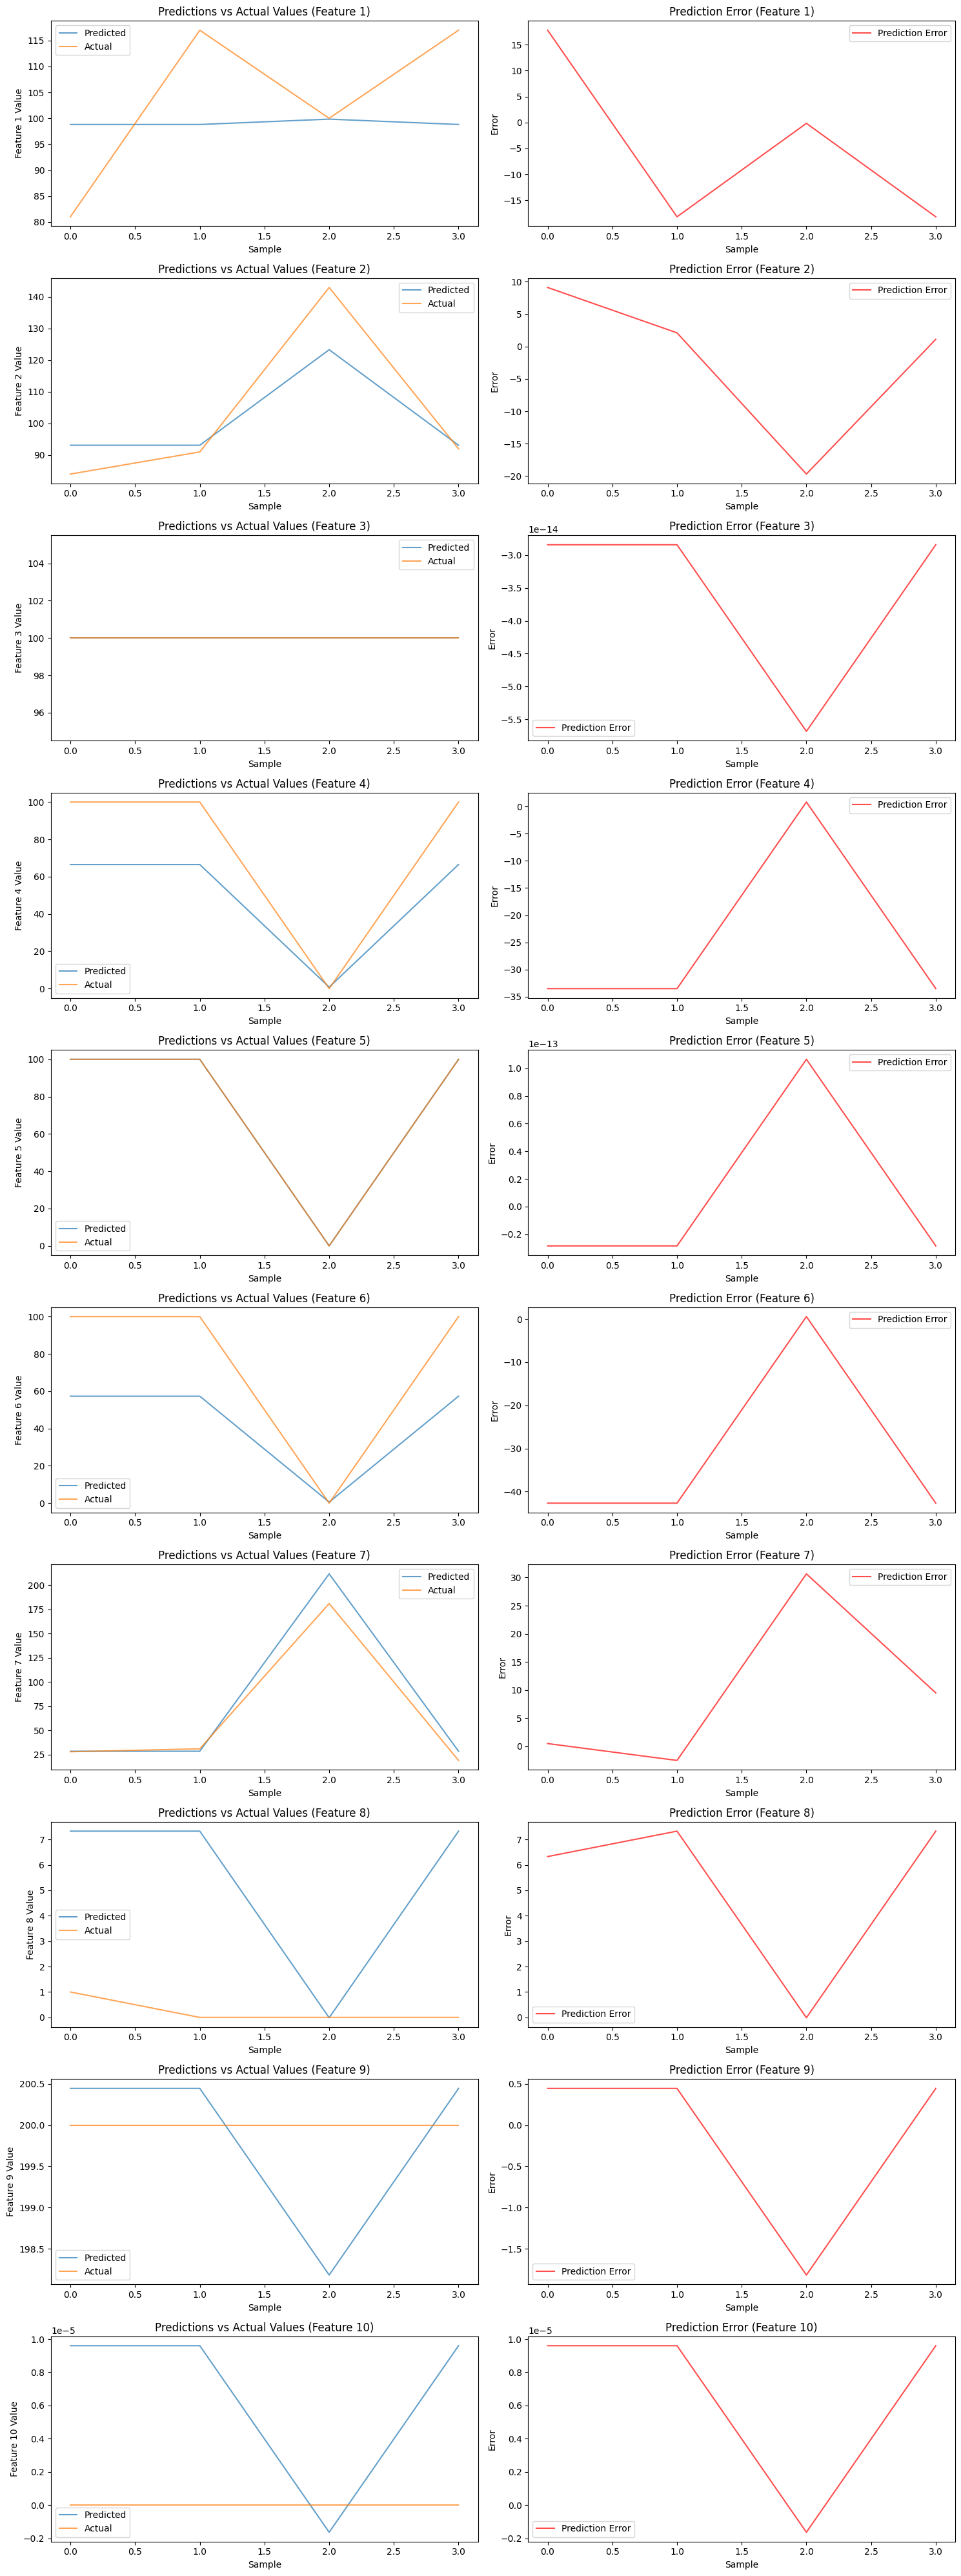

In [ ]:
# Plot predictions vs actual values for all features

num_features = test_predictions.shape[2]
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for i in range(num_features):
    # Predictions vs Actual
    axes[i, 0].plot(x, test_predictions[:num_samples_to_plot, 0, i], label='Predicted', alpha=0.7)
    axes[i, 0].plot(x, test_targets[:num_samples_to_plot, 0, i], label='Actual', alpha=0.7)
    axes[i, 0].set_xlabel("Sample")
    axes[i, 0].set_ylabel(f"Feature {i+1} Value")
    axes[i, 0].set_title(f"Predictions vs Actual Values (Feature {i+1})")
    axes[i, 0].legend()

    # Prediction Error
    error = test_predictions[:num_samples_to_plot, 0, i] - test_targets[:num_samples_to_plot, 0, i]
    axes[i, 1].plot(x, error, label='Prediction Error', color='red', alpha=0.7)
    axes[i, 1].set_xlabel("Sample")
    axes[i, 1].set_ylabel("Error")
    axes[i, 1].set_title(f"Prediction Error (Feature {i+1})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## Decision Tree Model
We will now train and test the Decision Tree model using the raw SMART data.

### Load the data to train the Decision Tree model

In [13]:

columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes', 'brand_DELLBOSS', 'brand_MTFDDAV', 'brand_HP', 'brand_CT', 'brand_SSDSCKKB', 'brand_Micron', 'date', 'serial_number']

In [14]:
try:
    print(f"normalized_rows: {normalized_rows}")
    print(f"Expected features: {len(normalized_rows)}")
except Exception as e:
    normalized_rows = [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
    print(f"normalized_rows: {normalized_rows}")
    print(f"Expected features: {len(normalized_rows)}")

raw_rows = []

normalized_rows: [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Expected features: 10


In [15]:
data = CT.importdata(ct_data_path, normalized_rows, raw_rows, columns_to_delete=columns_to_delete)


Processing CSV files: 100%|██████████| 1346/1346 [00:13<00:00, 101.92it/s]

Dataset Length:  76746
Dataset Shape:  (76746, 11)
Dataset:      failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
18    False               100.0               100.0               100.0   
2     False               100.0               139.0               100.0   
23    False                80.0                94.0               100.0   
20    False                80.0                92.0               100.0   
28    False               119.0                92.0               100.0   

    smart_184_normalized  smart_187_normalized  smart_189_normalized  \
18                   0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
23                   0.0                 100.0                   0.0   
20                 100.0                 100.0                 100.0   
28                 100.0                 100.0                 100.0   

    smart_194_normalized  smart_195_normalized  smart_1

In [16]:
print(data.columns.tolist())

['failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


In [17]:

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Original dataset shape: (76746, 11)
Original class distribution - No Failure: 63955, Failure: 12791
Original imbalance ratio: 5.00:1
Training set shape: (53722, 10)
Test set shape: (23024, 10)
Train class distribution - No Failure: 44768, Failure: 8954
Test class distribution - No Failure: 19187, Failure: 3837
\nApplying balancing strategy: smote_tomek


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After balancing - No Failure: 44573, Failure: 44573
Balanced ratio: 1.00:1
Training set size: 53722 -> 89146 samples


In [18]:
from collections import Counter

print("Original class distribution:", Counter(Y))
print("Resampled train class distribution:", Counter(y_train_res))
print("Test class distribution:", Counter(y_test))

Original class distribution: Counter({np.False_: 63955, np.True_: 12791})
Resampled train class distribution: Counter({np.False_: 44573, np.True_: 44573})
Test class distribution: Counter({np.False_: 19187, np.True_: 3837})


In [19]:
# # Grid search for best hyperparameters (Gini)
# print("\nPerforming grid search for Decision Tree (Gini)...")
# best_params, best_score = CT.grid_search_decision_tree(X_train_res, y_train_res)
# depth = best_params['max_depth']
# leaf = best_params['min_samples_leaf']

### Train both decision tree models

In [20]:
depth = 8
leaf = 4

In [21]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res, 
                               depth=depth, leaf=leaf, 
                               class_weight='balanced', 
                               failure_importance_factor=3.0)


Training Decision Tree with Gini criterion...
Custom class weights with 3.0x failure importance:
  Not Failed: 1.000
  Failed: 3.000

Top 5 most important features for failure detection:
  1. Feature 6: 0.3498
  2. Feature 4: 0.3225
  3. Feature 7: 0.1039
  4. Feature 1: 0.0810
  5. Feature 3: 0.0466


In [22]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res, 
                                     depth=depth, leaf=leaf,
                                     class_weight='balanced', 
                                     failure_importance_factor=3.0)  # 3x importance on failures


Training Decision Tree with Entropy criterion...
Custom class weights with 3.0x failure importance:
  Not Failed: 1.000
  Failed: 3.000

Top 5 most important features for failure detection (Entropy):
  1. Feature 4: 0.6409
  2. Feature 7: 0.0993
  3. Feature 6: 0.0794
  4. Feature 1: 0.0655
  5. Feature 0: 0.0511


### Test models

In [23]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[ True False  True ...  True  True  True]


In [24]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini", model_dir="../models/DT")


Results Using Gini Index:
Predicted values:
[ True False  True ...  True  True  True]
Confusion Matrix:  [[9662 9525]
 [ 539 3298]]
Accuracy :  56.28908964558721
Report :                precision    recall  f1-score   support

       False       0.95      0.50      0.66     19187
        True       0.26      0.86      0.40      3837

    accuracy                           0.56     23024
   macro avg       0.60      0.68      0.53     23024
weighted avg       0.83      0.56      0.61     23024

FP:  9525.0
FN:  539.0
TP:  3298.0
TN:  9662.0
TPR:  0.8595256710972113
TNR:  0.503570125605879
PPV:  0.25719410434375733
NPV:  0.9471620429369669
FPR:  0.496429874394121
FNR:  0.14047432890278863
FDR:  0.7428058956562427
ACC:  0.5628908964558721
❌ New gini model accuracy (0.5629) not better than previous best (0.8801)


In [25]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy", model_dir="../models/DT")


Results Using Entropy:
Predicted values:
[ True False  True ...  True  True  True]
Confusion Matrix:  [[ 9063 10124]
 [  473  3364]]
Accuracy :  53.97411396803336
Report :                precision    recall  f1-score   support

       False       0.95      0.47      0.63     19187
        True       0.25      0.88      0.39      3837

    accuracy                           0.54     23024
   macro avg       0.60      0.67      0.51     23024
weighted avg       0.83      0.54      0.59     23024

FP:  10124.0
FN:  473.0
TP:  3364.0
TN:  9063.0
TPR:  0.8767266093302059
TNR:  0.47235107103768176
PPV:  0.24940688018979834
NPV:  0.9503984899328859
FPR:  0.5276489289623182
FNR:  0.1232733906697941
FDR:  0.7505931198102017
ACC:  0.5397411396803335
❌ New entropy model accuracy (0.5397) not better than previous best (0.8807)


0.5397411396803335

### Save models

In [26]:
# Directory to store models
dt_model_dir = "../models/DT"
os.makedirs(dt_model_dir, exist_ok=True)

# Paths for Gini and Entropy models
gini_model_path = os.path.join(dt_model_dir, "dt_gini.joblib")
entropy_model_path = os.path.join(dt_model_dir, "dt_entropy.joblib")

# Helper function to load accuracy if model exists
def load_existing_accuracy(model_path):
    acc_path = model_path + ".acc"
    if os.path.exists(acc_path):
        with open(acc_path, "r") as f:
            return float(f.read().strip())
    return None

# Save model and accuracy
def save_model_and_accuracy(model, model_path, accuracy):
    joblib.dump(model, model_path)
    with open(model_path + ".acc", "w") as f:
        f.write(str(accuracy))

# Check and save Gini model if better
existing_gini_acc = load_existing_accuracy(gini_model_path)
if existing_gini_acc is None or gini_accuracy > existing_gini_acc:
    save_model_and_accuracy(clf_gini, gini_model_path, gini_accuracy)
    print(f"Saved improved Gini model with accuracy {gini_accuracy:.4f}")

# Check and save Entropy model if better
existing_entropy_acc = load_existing_accuracy(entropy_model_path)
entropy_accuracy = CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")
if existing_entropy_acc is None or entropy_accuracy > existing_entropy_acc:
    save_model_and_accuracy(clf_entropy, entropy_model_path, entropy_accuracy)
    print(f"Saved improved Entropy model with accuracy {entropy_accuracy:.4f}")

Confusion Matrix:  [[ 9063 10124]
 [  473  3364]]
Accuracy :  53.97411396803336
Report :                precision    recall  f1-score   support

       False       0.95      0.47      0.63     19187
        True       0.25      0.88      0.39      3837

    accuracy                           0.54     23024
   macro avg       0.60      0.67      0.51     23024
weighted avg       0.83      0.54      0.59     23024

FP:  10124.0
FN:  473.0
TP:  3364.0
TN:  9063.0
TPR:  0.8767266093302059
TNR:  0.47235107103768176
PPV:  0.24940688018979834
NPV:  0.9503984899328859
FPR:  0.5276489289623182
FNR:  0.1232733906697941
FDR:  0.7505931198102017
ACC:  0.5397411396803335
❌ New entropy model accuracy (0.5397) not better than previous best (0.8807)


### Visualize the results

In [27]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

In [28]:
# CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'], save_path="../reports/figures/decision_tree_gini.png")

In [29]:
# CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'], save_path="../reports/figures/decision_tree_entropy.png")

## Pipeline: LSTM + Decision Tree

In [33]:
path = "../data/testing_data/testing_data_processed/"
verbose = True    # Create a single data loader that handles the train/test split properly
model_path = '../models/LSTM/lstm_model.pth'

We load all the data to choose randomly drives to generate predictions from

In [34]:
columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes']

In [35]:
num_drives = 13
data_loader = smart.DriveDataLoader(root=path, 
                                train_ratio=0.01, # we are going to use only the testing data
                                min_sequence_length=min_sequence_length + 1,  # to have 1 day to test  
                                verbose=False, num_drives=num_drives,
                                columns_to_delete=columns_to_delete, normalized_rows=normalized_rows, raw_rows=raw_rows)

NameError: name 'min_sequence_length' is not defined

In [ ]:
selected_drives = data_loader.get_all_data()

print(f"Loaded {len(selected_drives)} days from the dataset from {num_drives} drives.")


Loaded 100 days from the dataset from 13 drives.


In [ ]:
# Extract the last day for each drive and store in a DataFrame
last_days_df = selected_drives.groupby('serial_number').tail(1).reset_index(drop=True)
print(last_days_df)

          date serial_number  failure  smart_1_normalized  smart_3_normalized  \
0   2019-10-25      AAH9633H    False                 100                 100   
1   2019-12-14      S300Z415    False                 119                  97   
2   2019-09-21      S300Z6YV    False                 117                  92   
3   2019-10-25      Z302BLRN    False                 118                  92   
4   2019-06-28      Z302SR8J    False                 117                  96   
5   2019-10-10      Z305K29H    False                 110                  99   
6   2019-04-28      Z305KBGC    False                 118                  94   
7   2019-10-10      ZA130JWV    False                  83                  96   
8   2019-04-28      ZA14F198    False                  79                  94   
9   2019-06-25      ZA154X5T    False                  83                  86   
10  2019-07-19      ZA172F47    False                  80                  93   
11  2019-02-20      ZCH070PC

In [ ]:
model_path = '../models/LSTM/lstm_model.pth'
model, model_metrics = smart.load_model(model_path, device, load_whole_model=True)

✅ Complete model loaded from ../models/LSTM/lstm_model.joblib
✅ Model metrics loaded from ../models/LSTM/lstm_model_metrics.json


In [ ]:
model.eval()

Net(
  (lstm): LSTM(10, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=10, bias=True)
)

In [ ]:
ct_feature_list = []
for row in normalized_rows:
    ct_feature_list.append(f'smart_{row}_normalized')
for row in raw_rows:
    ct_feature_list.append(f'smart_{row}_raw')
ct_feature_list += ['serial_number']
predicted_info = pd.DataFrame(columns=ct_feature_list)

predicted_info

,smart_187_normalized,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_195_normalized,smart_199_normalized,smart_194_normalized,smart_184_normalized,smart_189_normalized,smart_222_normalized,serial_number


In [ ]:

for serial, drive_df in tqdm(selected_drives.groupby('serial_number'), desc="Processing drives"):
    # Prepare your input sequence for the LSTM
    features = drive_df.drop(columns=['serial_number', 'date', 'failure']).values
    # Keep only columns from normalized_rows and raw_rows
    cols_to_keep = [f"smart_{i}_normalized" for i in normalized_rows] + [f"smart_{i}_raw" for i in raw_rows]
    features = drive_df[cols_to_keep].values
    # Convert to tensor and add batch/sequence dimensions as needed, and use float62
    input_tensor = torch.tensor(features, dtype=torch.float64).unsqueeze(0)  # shape: [1, seq_len, features]
    # Run through model
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
        last_day_pred = prediction[:, -1, :].cpu().numpy().flatten()
        # Map last_day_pred to ct_feature_list and append to predicted_info
        pred_row = dict(zip(ct_feature_list, last_day_pred))
        pred_row['serial_number'] = serial
        predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)

Processing drives:   0%|          | 0/13 [00:00<?, ?it/s]C:\Users\Green\AppData\Local\Temp\ipykernel_32604\387405974.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)
Processing drives: 100%|██████████| 13/13 [00:00<00:00, 399.11it/s]


In [ ]:
print(predicted_info)

    smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             111.444269          100.224161           88.358219   
1             103.647905           89.788251           99.403246   
2             103.647986           89.788330           99.403333   
3             103.647388           89.787742           99.402686   
4             103.647905           89.788251           99.403246   
5             103.647388           89.787742           99.402686   
6             103.647984           89.788329           99.403332   
7             103.647984           89.788329           99.403332   
8             103.647388           89.787743           99.402686   
9             103.647905           89.788251           99.403246   
10            103.647985           89.788330           99.403334   
11            103.637504           89.794140           99.409865   
12            103.645286           89.790106           99.405325   

    smart_5_normalized  smart_195_normalized  s

In [ ]:
clf_gini = load("../models/DT/dt_gini.joblib")
clf_entropy = load("../models/DT/dt_entropy.joblib")

In [ ]:
serial_numbers = predicted_info['serial_number'].unique()

In [ ]:
# Only use the feature columns for prediction to avoid warnings
feature_cols = []

# Add normalized columns
for row in normalized_rows:
    feature_cols.append(f'smart_{row}_normalized')

# Add raw columns  
for row in raw_rows:
    feature_cols.append(f'smart_{row}_raw')

print("Formatted feature columns:")
print(feature_cols)


Formatted feature columns:
['smart_187_normalized', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_194_normalized', 'smart_184_normalized', 'smart_189_normalized', 'smart_222_normalized']


In [ ]:
ct_predictions_gini = CT.prediction(predicted_info[feature_cols].values, clf_gini)
ct_predictions_entropy = CT.prediction(predicted_info[feature_cols].values, clf_entropy)

# Add predictions to the DataFrame
predicted_info['CT_Drive_Failed'] = ct_predictions_entropy
print(predicted_info)


Predicted values:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
Predicted values:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
    smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             111.444269          100.224161           88.358219   
1             103.647905           89.788251           99.403246   
2             103.647986           89.788330           99.403333   
3             103.647388           89.787742           99.402686   
4             103.647905           89.788251           99.403246   
5             103.647388           89.787742           99.402686   
6             103.647984           89.788329           99.403332   
7             103.647984           89.788329           99.403332   
8             103.647388           89.787743           99.402686   
9             103.647905           89.788251           99.403246   
10            103.647985           89.788330          

### Compare the results of the LSTM and Decision Tree models

In [ ]:

# Compare predicted failure with actual failure for each drive
last_days_df_sorted = last_days_df.set_index('serial_number').loc[serial_numbers].reset_index()
predicted_info['Actual_Failure'] = last_days_df_sorted['failure'].values

# Optionally, print a comparison summary
comparison = predicted_info[['CT_Drive_Failed', 'Actual_Failure']]
print("Prediction vs Actual Failure:\n", comparison)

print("accuracy:", (predicted_info['CT_Drive_Failed'] == predicted_info['Actual_Failure']).mean())

# FIXED VALIDATION: Proper alignment and comprehensive checks
print("="*60)
print("VALIDATION OF PREDICTIONS VS ACTUAL FAILURES")
print("="*60)

# Step 1: Verify data alignment
print(f"Number of predictions: {len(predicted_info)}")
print(f"Number of actual records: {len(last_days_df)}")
print(f"Unique serial numbers in predictions: {len(predicted_info['serial_number'].unique())}")
print(f"Unique serial numbers in actual data: {len(last_days_df['serial_number'].unique())}")

# Step 2: Check if all predicted serial numbers exist in actual data
predicted_serials = set(predicted_info['serial_number'])
actual_serials = set(last_days_df['serial_number'])

missing_in_actual = predicted_serials - actual_serials
missing_in_predicted = actual_serials - predicted_serials

if missing_in_actual:
    print(f"⚠️  WARNING: {len(missing_in_actual)} serial numbers in predictions not found in actual data:")
    print(f"   {list(missing_in_actual)[:5]}...")  # Show first 5

if missing_in_predicted:
    print(f"⚠️  WARNING: {len(missing_in_predicted)} serial numbers in actual data not found in predictions:")
    print(f"   {list(missing_in_predicted)[:5]}...")  # Show first 5

# Step 3: Create proper alignment using merge instead of index-based alignment
print(f"\n🔄 Merging predictions with actual data using serial_number as key...")

# Merge on serial_number to ensure proper alignment
validation_df = predicted_info.merge(
    last_days_df[['serial_number', 'failure']], 
    on='serial_number', 
    how='inner',  # Only keep records that exist in both datasets
    suffixes=('_predicted', '_actual')
)

# Rename for clarity
validation_df['Actual_Failure'] = validation_df['failure']
validation_df = validation_df.drop('failure', axis=1)

print(f"✅ Successfully aligned {len(validation_df)} records")

# Step 4: Detailed validation analysis
print(f"\n📊 VALIDATION RESULTS:")
print("-" * 40)

# Basic accuracy
correct_predictions = (validation_df['CT_Drive_Failed'] == validation_df['Actual_Failure']).sum()
total_predictions = len(validation_df)
accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {accuracy:.3f} ({correct_predictions}/{total_predictions})")

# Confusion matrix breakdown
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(validation_df['Actual_Failure'], validation_df['CT_Drive_Failed'])
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"Actual    No Fail  Fail")
print(f"No Fail   {cm[0,0]:6d}  {cm[0,1]:4d}")
print(f"Fail      {cm[1,0]:6d}  {cm[1,1]:4d}")

# Calculate metrics for each class
tn, fp, fn, tp = cm.ravel()

# Metrics for failure detection (most important)
if (tp + fn) > 0:  # Avoid division by zero
    failure_recall = tp / (tp + fn)  # How many actual failures we caught
    print(f"\n🚨 FAILURE DETECTION METRICS (Most Important):")
    print(f"   Failure Recall (Sensitivity): {failure_recall:.3f}")
    print(f"   → We detected {tp} out of {tp + fn} actual failures")
    print(f"   → We missed {fn} actual failures")
else:
    print(f"\n⚠️  No actual failures in the test set!")

if (tp + fp) > 0:  # Avoid division by zero
    failure_precision = tp / (tp + fp)  # When we predict failure, how often are we right
    print(f"   Failure Precision: {failure_precision:.3f}")
    print(f"   → {tp} out of {tp + fp} failure predictions were correct")
    print(f"   → {fp} were false alarms")

# Metrics for non-failure detection
if (tn + fp) > 0:
    no_failure_recall = tn / (tn + fp)
    print(f"\n✅ NON-FAILURE DETECTION METRICS:")
    print(f"   No-Failure Recall (Specificity): {no_failure_recall:.3f}")
    print(f"   → We correctly identified {tn} out of {tn + fp} healthy drives")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(
    validation_df['Actual_Failure'], 
    validation_df['CT_Drive_Failed'],
    target_names=['No Failure', 'Failure'],
    digits=3
))

# Step 5: Show individual predictions for review
print(f"\n🔍 INDIVIDUAL PREDICTION REVIEW:")
print("-" * 50)

# Show all predictions with their outcomes
comparison_df = validation_df[['serial_number', 'CT_Drive_Failed', 'Actual_Failure']].copy()
comparison_df['Prediction_Result'] = comparison_df.apply(
    lambda row: 'Correct' if row['CT_Drive_Failed'] == row['Actual_Failure'] 
                else ('False Positive' if row['CT_Drive_Failed'] == 1 
                      else 'False Negative'), 
    axis=1
)

print(comparison_df.to_string(index=False))

# Step 6: Highlight critical cases
false_negatives = comparison_df[comparison_df['Prediction_Result'] == 'False Negative']
false_positives = comparison_df[comparison_df['Prediction_Result'] == 'False Positive']

if len(false_negatives) > 0:
    print(f"\n🔴 CRITICAL: {len(false_negatives)} MISSED FAILURES (False Negatives):")
    for _, row in false_negatives.iterrows():
        print(f"   Serial: {row['serial_number']} - ACTUAL FAILURE MISSED!")

if len(false_positives) > 0:
    print(f"\n🟡 {len(false_positives)} FALSE ALARMS (False Positives):")
    for _, row in false_positives.iterrows():
        print(f"   Serial: {row['serial_number']} - False alarm (healthy drive)")

# Step 7: Business impact assessment
print(f"\n💼 BUSINESS IMPACT ASSESSMENT:")
print("-" * 40)
if (tp + fn) > 0:
    prevented_failures = tp
    missed_failures = fn
    total_actual_failures = tp + fn
    
    print(f"✅ Prevented failures: {prevented_failures}")
    print(f"❌ Missed failures: {missed_failures}")
    print(f"📊 Failure prevention rate: {(prevented_failures/total_actual_failures)*100:.1f}%")
    
    # Estimated cost savings (example values - adjust based on your business)
    cost_per_failure = 10000  # Example: $10,000 per unplanned failure
    cost_per_false_alarm = 500  # Example: $500 per unnecessary replacement
    
    savings = prevented_failures * cost_per_failure
    false_alarm_cost = fp * cost_per_false_alarm
    net_savings = savings - false_alarm_cost
    
    print(f"\n💰 ESTIMATED FINANCIAL IMPACT:")
    print(f"   Savings from prevented failures: ${savings:,}")
    print(f"   Cost of false alarms: ${false_alarm_cost:,}")
    print(f"   Net savings: ${net_savings:,}")

print(f"\n" + "="*60)
print("VALIDATION COMPLETE")
print("="*60)



Prediction vs Actual Failure:
     CT_Drive_Failed  Actual_Failure
0              True           False
1              True           False
2              True           False
3              True           False
4              True           False
5              True           False
6              True           False
7              True           False
8              True           False
9              True           False
10             True           False
11             True           False
12             True           False
accuracy: 0.0
VALIDATION OF PREDICTIONS VS ACTUAL FAILURES
Number of predictions: 13
Number of actual records: 13
Unique serial numbers in predictions: 13
Unique serial numbers in actual data: 13

🔄 Merging predictions with actual data using serial_number as key...
✅ Successfully aligned 13 records

📊 VALIDATION RESULTS:
----------------------------------------
Overall Accuracy: 0.000 (0/13)

Confusion Matrix:
                 Predicted
Actual    No Fail  Fail


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\